# Imorting Libraries and Files

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from pybaseball import pitching_stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP.models import ModelSpec as MS, summarize, poly

In [2]:
pitchers_data = pd.read_csv('Pitchers_Data.csv')
pitchers_data.head()

,Name,xERA,EV,Contact%,AVG,K%,FBv,CTv,CBv,CHv,Location+
0,Chris Sale,2.79,86.5,0.711,0.215,0.321,94.8,90.4,79.3,86.9,111
1,Tarik Skubal,2.72,87.4,0.717,0.200,0.303,96.8,92.3,78.5,86.3,100
2,Zack Wheeler,2.85,86.7,0.747,0.191,0.285,95.1,91.1,81.8,85.6,104
3,Cole Ragans,3.31,88.3,0.705,0.212,0.293,95.4,91.0,80.8,84.8,99
4,Seth Lugo,3.74,88.5,0.795,0.227,0.217,92.2,89.9,79.8,87.5,100


# Model 1: Fastballs, Cutters, Curveballs, and Change-Ups
* Working backwards, so every pitch will be included in the model.

In [3]:
all_pitches = pitchers_data[['FBv', 'CTv', 'CBv', 'CHv', 'xERA']]
all_pitches_v = all_pitches.columns.drop('xERA')
x1 = MS(all_pitches_v).fit_transform(all_pitches)
y1 = all_pitches['xERA']
model1 = sm.OLS(y1, x1)
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xERA   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     4.756
Date:                Mon, 13 Oct 2025   Prob (F-statistic):            0.00236
Time:                        11:07:44   Log-Likelihood:                -42.050
No. Observations:                  58   AIC:                             94.10
Df Residuals:                      53   BIC:                             104.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.3139      4.066      4.996      0.000      12.159      28.469
FBv           -0.2243      0.071     -3.143      0.003      -0.367      -0.081
CTv            0.0349      0.053      0.662      0.511      -0.071       0.141
CBv            0.0297      0.031      0.966      0.338      -0.032       0.091
CHv           -0.0096      0.023     -0.408      0.685      -0.057       0.038
==============================================================================
Omnibus:                        1.030   Durbin-Watson:                   1.303
Prob(Omnibus):                  0.597   Jarque-Bera (JB):                0.972
Skew:                           0.129   Prob(JB):                        0.615
Kurtosis:                       2.421   Cond. No.                     1.03e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.02, 'Model 1 Scatterplot')

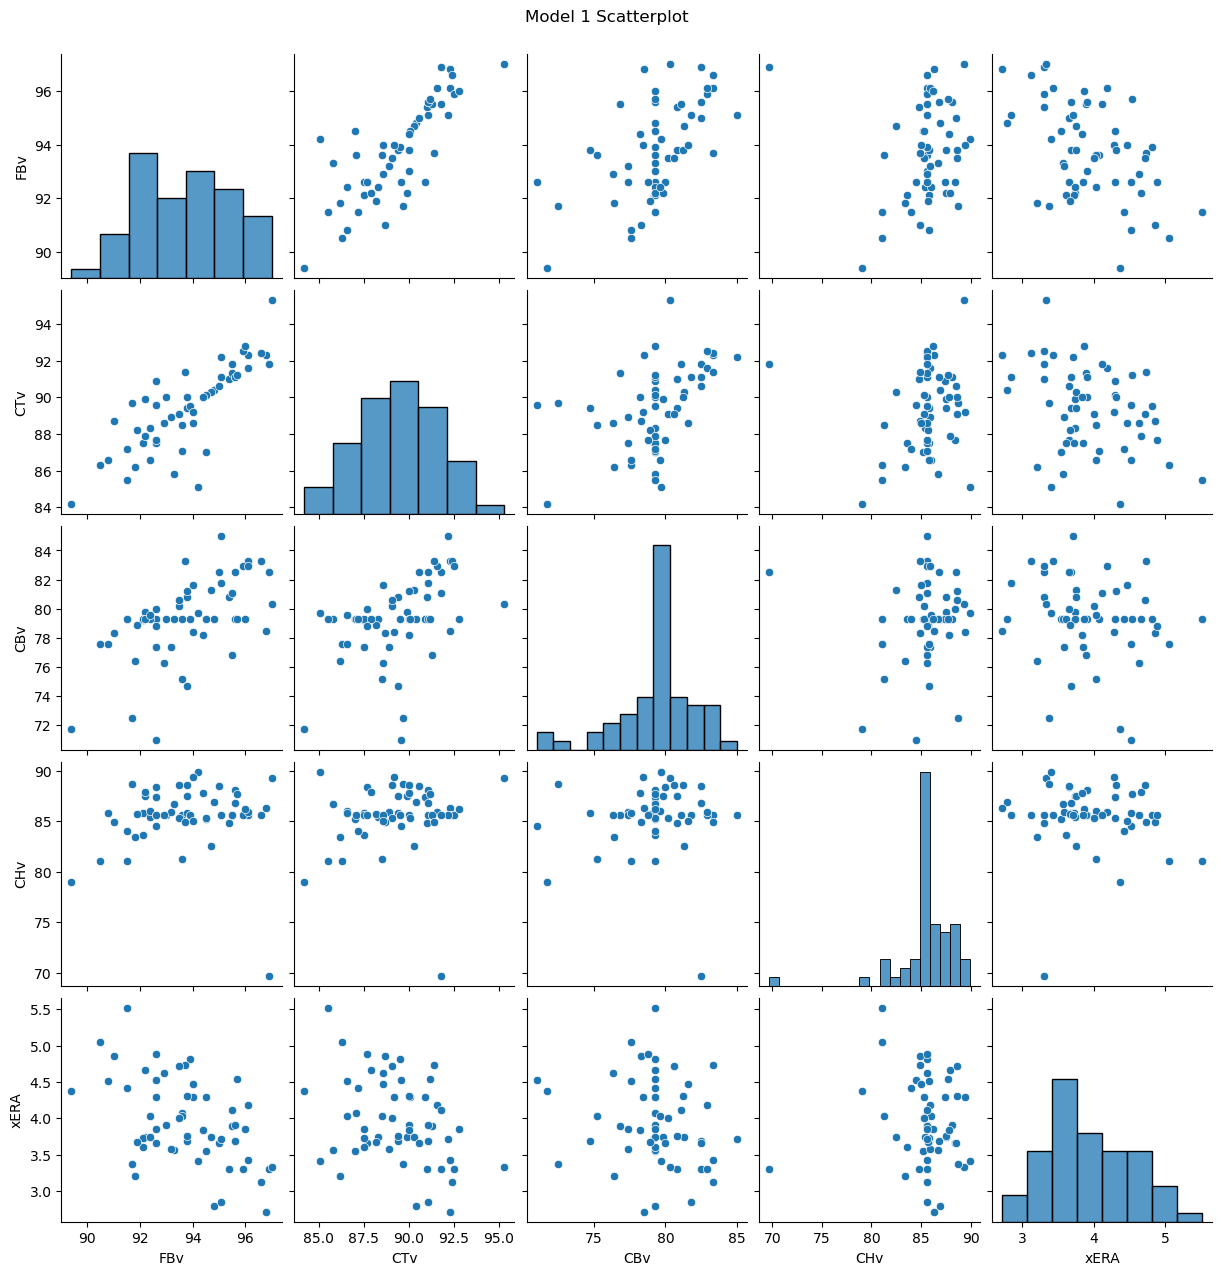

In [4]:
# Displaying a scatterplot matrix of Model 1
all_pitches = all_pitches.copy()
scat1 = sns.pairplot(all_pitches)
scat1.fig.suptitle("Model 1 Scatterplot", y=1.02)

In [5]:
# Finding VIF (since there is a great chance of multicollinearity)
vals1 = [VIF(x1, i) for i in range(1, x1.shape[1])]
vif1 = pd.DataFrame({'vif': vals1}, index=x1.columns[1:])
vif1

,vif
FBv,3.298983
CTv,2.899722
CBv,1.455380
CHv,1.024723


In [6]:
# Finding outliers in the dataset
all_pitches_only_df = all_pitches.copy()
all_pitches_only_df = all_pitches_only_df.drop('xERA', axis=1)
z_scores1 = np.abs(stats.zscore(all_pitches_only_df))
z_scores_df1 = pd.DataFrame(z_scores1, columns=all_pitches_only_df.columns)
outliers1 = np.where((z_scores1 > 3).any(axis=1))[0]
print("Outliers:", outliers1)
print("Number of outliers:", len(outliers1))
print(all_pitches.loc[outliers1])

Outliers: [ 5 39]
Number of outliers: 2
     FBv   CTv   CBv   CHv  xERA
5   96.9  91.8  82.5  69.7  3.31
39  92.6  89.6  71.0  84.5  4.53


In [7]:
# Finding high inluence values
influence1 = results1.get_influence()
(c1, p1) = influence1.cooks_distance
high_influence1_df = pd.DataFrame()
high_influence1_df['cooks_d'] = c1
high_influence1_df['leverage'] = influence1.hat_matrix_diag
n1 = len(high_influence1_df)
threshold1 = 4 / n1
high_influence1_df['high_influence'] = high_influence1_df['cooks_d'] > threshold1
high_influence_indices1 = np.where(high_influence1_df['high_influence'])[0]
print(all_pitches.loc[high_influence_indices1])
print()
print(high_influence1_df.head())

     FBv   CTv   CBv   CHv  xERA
5   96.9  91.8  82.5  69.7  3.31
24  91.7  89.7  72.5  88.7  3.38
39  92.6  89.6  71.0  84.5  4.53
47  91.5  85.5  79.3  81.1  5.52

    cooks_d  leverage  high_influence
0  0.020376  0.029498           False
1  0.038992  0.111966           False
2  0.023539  0.034881           False
3  0.003836  0.034929           False
4  0.025951  0.090976           False


In [8]:
# Removing high influence values from model
all_pitches_11 = all_pitches
all_pitches_11 = all_pitches_11.drop(high_influence_indices1)
print(all_pitches_11.shape)
all_pitches_11.head()

(54, 5)


,FBv,CTv,CBv,CHv,xERA
0,94.8,90.4,79.3,86.9,2.79
1,96.8,92.3,78.5,86.3,2.72
2,95.1,91.1,81.8,85.6,2.85
3,95.4,91.0,80.8,84.8,3.31
4,92.2,89.9,79.8,87.5,3.74


In [9]:
# Model 1 without high infuence values
all_pitches_v11 = all_pitches_11.columns.drop('xERA')
print(all_pitches_11.shape)
x11 = MS(all_pitches_v11).fit_transform(all_pitches_11)
y11 = all_pitches_11['xERA']
model11 = sm.OLS(y11, x11)
results11 = model11.fit()
results11.summary()

(54, 5)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xERA   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     4.398
Date:                Mon, 13 Oct 2025   Prob (F-statistic):            0.00407
Time:                        11:07:45   Log-Likelihood:                -35.691
No. Observations:                  54   AIC:                             81.38
Df Residuals:                      49   BIC:                             91.33
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.4497      4.020      4.589      0.000      10.370      26.529
FBv           -0.2439      0.071     -3.431      0.001      -0.387      -0.101
CTv            0.0713      0.054      1.331      0.189      -0.036       0.179
CBv            0.0120      0.036      0.333      0.741      -0.061       0.085
CHv            0.0119      0.037      0.322      0.749      -0.063       0.086
==============================================================================
Omnibus:                        1.082   Durbin-Watson:                   1.230
Prob(Omnibus):                  0.582   Jarque-Bera (JB):                0.924
Skew:                           0.017   Prob(JB):                        0.630
Kurtosis:                       2.360   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Model 2: Fastballs, Cutters, and Curveballs
* Removing Change-Ups because there is evidence of high multicollinearity.

In [10]:
pitches_minus_chv_df = pitchers_data[['FBv', 'CTv', 'CBv', 'xERA']]
excluding_ch = pitches_minus_chv_df.columns.drop('xERA')
x2 = MS(excluding_ch).fit_transform(pitches_minus_chv_df)
y2 = pitches_minus_chv_df['xERA']
model2 = sm.OLS(y2, x2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xERA   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     6.384
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           0.000879
Time:                        11:07:45   Log-Likelihood:                -42.141
No. Observations:                  58   AIC:                             92.28
Df Residuals:                      54   BIC:                             100.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.6252      3.671      5.347      0.000      12.266      26.984
FBv           -0.2230      0.071     -3.153      0.003      -0.365      -0.081
CTv            0.0324      0.052      0.623      0.536      -0.072       0.136
CBv            0.0294      0.031      0.964      0.339      -0.032       0.091
==============================================================================
Omnibus:                        0.845   Durbin-Watson:                   1.313
Prob(Omnibus):                  0.655   Jarque-Bera (JB):                0.872
Skew:                           0.129   Prob(JB):                        0.647
Kurtosis:                       2.457   Cond. No.                     8.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.02, 'Model 2 Scatterplot')

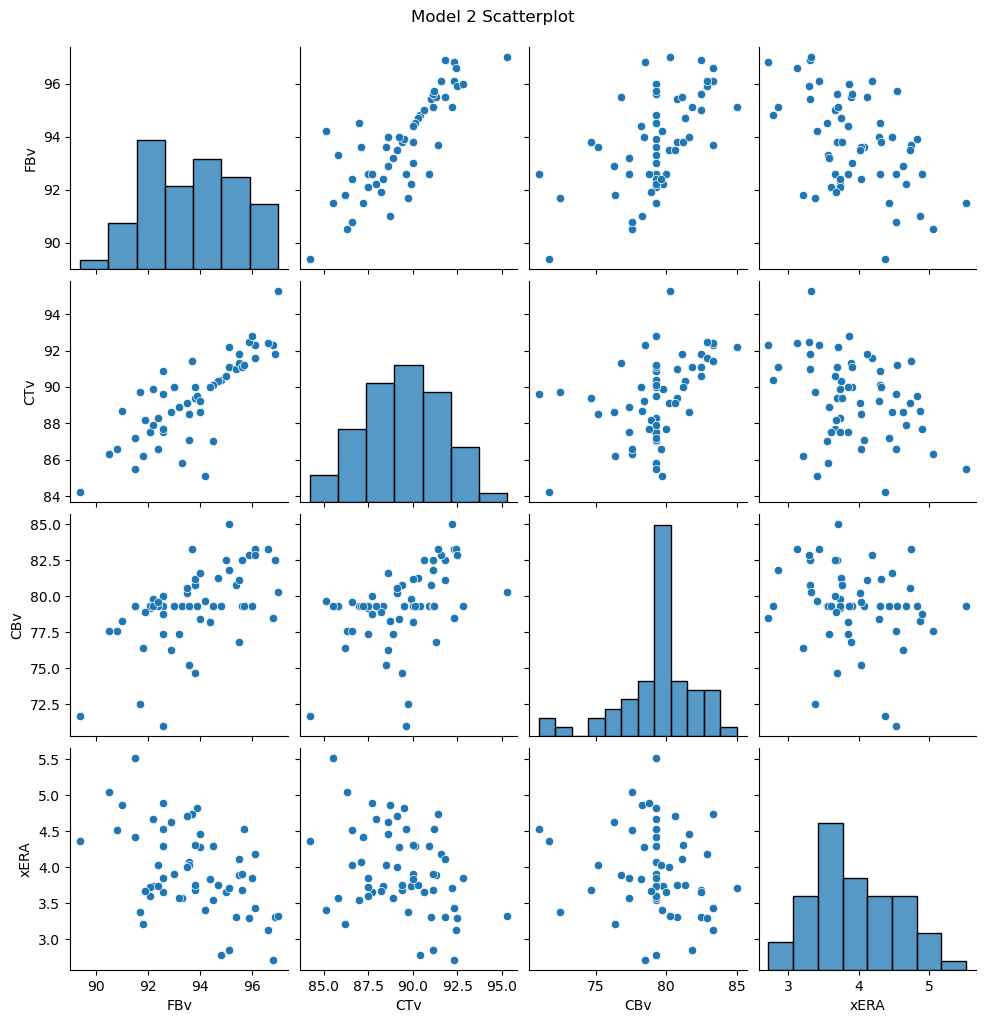

In [11]:
# Displaying a scatterplot matrix of Model 2
pitches_minus_chv_df = pitches_minus_chv_df.copy()
scat2 = sns.pairplot(pitches_minus_chv_df)
scat2.fig.suptitle('Model 2 Scatterplot', y=1.02)

In [12]:
# Finding outliers in the dataset
pitches_minus_chv_df['xERA'] = pitchers_data['xERA']
z_scores2 = np.abs(stats.zscore(pitches_minus_chv_df))
z_scores_df2 = pd.DataFrame(z_scores2, columns=pitches_minus_chv_df.columns)
outliers2 = np.where((z_scores2 > 3).any(axis=1))[0]
print('Outliers:', outliers2)
print('Number of Outliers:', len(outliers2))
print(pitches_minus_chv_df.loc[outliers2])

Outliers: [39]
Number of Outliers: 1
     FBv   CTv   CBv  xERA
39  92.6  89.6  71.0  4.53


In [13]:
# Finding high influence values
influence2 = results2.get_influence()
(c2, p2) = influence2.cooks_distance
high_influence2_df = pd.DataFrame()
high_influence2_df['cooks_d'] = c2
high_influence2_df['leverage'] = influence2.hat_matrix_diag
n2 = len(high_influence2_df)
threshold2 = 3 / n2
high_influence2_df['high_influence'] = high_influence2_df['cooks_d'] > threshold2
high_influence_indices2 = np.where(high_influence2_df['high_influence'])[0]
print(pitches_minus_chv_df.loc[high_influence_indices2])
print()
print(high_influence2_df.head())

     FBv   CTv   CBv  xERA
24  91.7  89.7  72.5  3.38
29  91.8  86.2  76.4  3.21
39  92.6  89.6  71.0  4.53
47  91.5  85.5  79.3  5.52

    cooks_d  leverage  high_influence
0  0.023745  0.026585           False
1  0.049936  0.111664           False
2  0.029494  0.034670           False
3  0.004317  0.032806           False
4  0.032459  0.085986           False


In [14]:
# Removing high influence values from model
pitches_minus_chv_df22 = pitches_minus_chv_df
pitches_minus_chv_df22 = pitches_minus_chv_df22.drop(high_influence_indices2)
print(pitches_minus_chv_df22.shape)
pitches_minus_chv_df22.head()

(54, 4)


,FBv,CTv,CBv,xERA
0,94.8,90.4,79.3,2.79
1,96.8,92.3,78.5,2.72
2,95.1,91.1,81.8,2.85
3,95.4,91.0,80.8,3.31
4,92.2,89.9,79.8,3.74


In [15]:
# Model 2 without high influence values
excluding_ch22 = pitches_minus_chv_df22.columns.drop('xERA')
x22 = MS(excluding_ch22).fit_transform(pitches_minus_chv_df22)
y22 = pitches_minus_chv_df22['xERA']
model22 = sm.OLS(y22, x22)
results22 = model22.fit()
results22.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xERA   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     7.608
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           0.000276
Time:                        11:07:45   Log-Likelihood:                -33.595
No. Observations:                  54   AIC:                             75.19
Df Residuals:                      50   BIC:                             83.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.2027      3.499      5.774      0.000      13.175      27.231
FBv           -0.2379      0.065     -3.664      0.001      -0.368      -0.107
CTv            0.0611      0.051      1.200      0.236      -0.041       0.163
CBv            0.0075      0.034      0.220      0.826      -0.061       0.075
==============================================================================
Omnibus:                        0.885   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.643   Jarque-Bera (JB):                0.860
Skew:                           0.093   Prob(JB):                        0.651
Kurtosis:                       2.411   Cond. No.                     8.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Model 3: Fastballs and Curveballs
* Removing cutters from the model because there is evidence that there is still multicollinearity.

In [16]:
fb_cb_df = pitchers_data[['FBv', 'CBv', 'xERA']]
fb_cb_v = fb_cb_df.columns.drop('xERA')
x3 = MS(fb_cb_v).fit_transform(fb_cb_df)
y3 = fb_cb_df['xERA']
model3 = sm.OLS(y3, x3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xERA   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     9.487
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           0.000289
Time:                        11:07:45   Log-Likelihood:                -42.348
No. Observations:                  58   AIC:                             90.70
Df Residuals:                      55   BIC:                             96.88
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.4130      3.634      5.342      0.000      12.130      26.696
FBv           -0.1901      0.047     -4.066      0.000      -0.284      -0.096
CBv            0.0296      0.030      0.976      0.333      -0.031       0.090
==============================================================================
Omnibus:                        1.471   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.479   Jarque-Bera (JB):                1.162
Skew:                           0.113   Prob(JB):                        0.559
Kurtosis:                       2.345   Cond. No.                     6.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
# Finding VIF
vals3 = [VIF(x3, i) for i in range(1, x3.shape[1])]
vif3 = pd.DataFrame({'vif': vals3}, index=x3.columns[1:])
vif3

,vif
FBv,1.454387
CBv,1.454387


Text(0.5, 1.02, 'Model 3 Scatterplot')

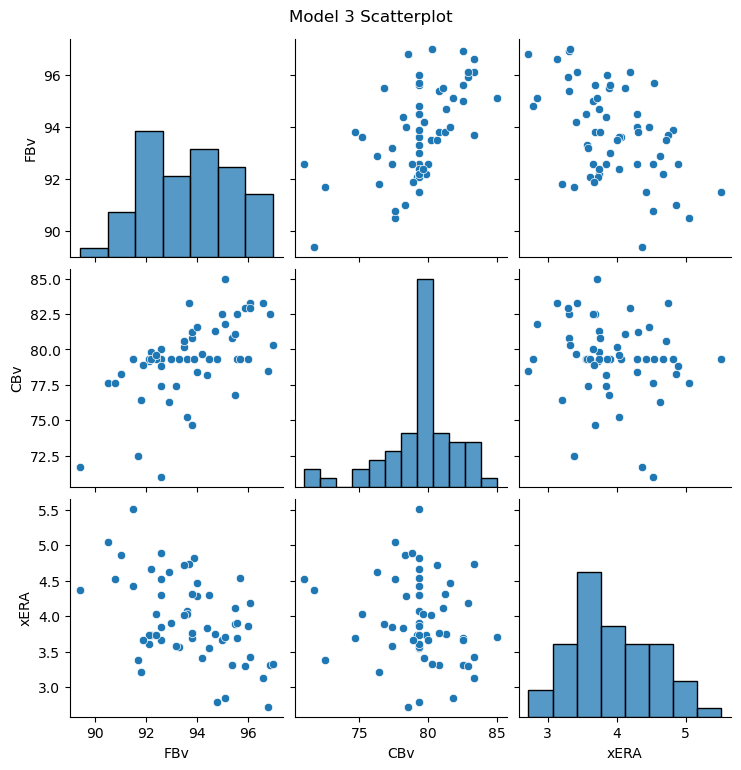

In [18]:
# Displaying a scatterplot matrix of Model 3
fb_cb_df = fb_cb_df.copy()
scat3 = sns.pairplot(fb_cb_df)
scat3.fig.suptitle('Model 3 Scatterplot', y=1.02)

In [19]:
# Finding outliers in the dataset
z_scores3 = np.abs(stats.zscore(fb_cb_df))
z_scores_df3 = pd.DataFrame(z_scores3, columns=fb_cb_df.columns)
outliers3 = np.where((z_scores3 > 3).any(axis=1))[0]
print('Outliers:', outliers3)
print('Number of outliers:', len(outliers3))
print(fb_cb_df.loc[outliers3])

Outliers: [39]
Number of outliers: 1
     FBv   CBv  xERA
39  92.6  71.0  4.53


In [20]:
# Finding high influence values
influence3 = results3.get_influence()
(c3, p3) = influence3.cooks_distance
high_influence3_df = pd.DataFrame()
high_influence3_df['cooks_d'] = c1
high_influence3_df['leverage'] = influence3.hat_matrix_diag
n3 = len(high_influence3_df)
threshold = 2 / n3
high_influence3_df['high_influence'] = high_influence3_df['cooks_d'] > threshold
high_influence_indices3 = np.where(high_influence3_df['high_influence'])[0]
print(fb_cb_df.loc[high_influence_indices3])
print()
print(high_influence3_df.head())

     FBv   CBv  xERA
1   96.8  78.5  2.72
5   96.9  82.5  3.31
24  91.7  72.5  3.38
29  91.8  76.4  3.21
39  92.6  71.0  4.53
43  95.7  79.3  4.54
47  91.5  79.3  5.52
53  93.7  83.3  4.74

    cooks_d  leverage  high_influence
0  0.020376  0.026562           False
1  0.038992  0.111346            True
2  0.023539  0.033577           False
3  0.003836  0.032759           False
4  0.025951  0.041988           False


In [21]:
# Removing high influence values from model
fb_cb_df33 = fb_cb_df
fb_cb_df33 = fb_cb_df33.drop(high_influence_indices3)
print(fb_cb_df33.shape)
fb_cb_df33.head()

(50, 3)


,FBv,CBv,xERA
0,94.8,79.3,2.79
2,95.1,81.8,2.85
3,95.4,80.8,3.31
4,92.2,79.8,3.74
6,94.5,79.3,3.55


In [22]:
# Model 3 without high influence values
fb_cb_v33 = fb_cb_df33.columns.drop('xERA')
x33 = MS(fb_cb_v33).fit_transform(fb_cb_df33)
y33 = fb_cb_df33['xERA']
model33 = sm.OLS(y33, x33)
results33 = model33.fit()
results33.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xERA   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     9.451
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           0.000355
Time:                        11:07:46   Log-Likelihood:                -29.011
No. Observations:                  50   AIC:                             64.02
Df Residuals:                      47   BIC:                             69.76
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.3183      3.538      5.460      0.000      12.201      26.436
FBv           -0.1608      0.047     -3.402      0.001      -0.256      -0.066
CBv           -0.0038      0.034     -0.112      0.911      -0.073       0.065
==============================================================================
Omnibus:                        0.958   Durbin-Watson:                   1.313
Prob(Omnibus):                  0.619   Jarque-Bera (JB):                0.872
Skew:                           0.065   Prob(JB):                        0.647
Kurtosis:                       2.366   Cond. No.                     6.90e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Model 4: Fastballs
# Removing curveballs from the model because curveballs are not significant.

In [23]:
fb_v_df = pitchers_data[['FBv', 'xERA']]
fb_v = fb_v_df[['FBv']]
x4 = MS(fb_v).fit_transform(fb_v_df)
y4 = fb_v_df[['xERA']]
model4 = sm.OLS(y4, x4)
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xERA   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     18.04
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           8.25e-05
Time:                        11:07:46   Log-Likelihood:                -42.847
No. Observations:                  58   AIC:                             89.69
Df Residuals:                      56   BIC:                             93.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     19.3717      3.633      5.333      0.000      12.095      26.649
FBv           -0.1645      0.039     -4.247      0.000      -0.242      -0.087
==============================================================================
Omnibus:                        0.617   Durbin-Watson:                   1.350
Prob(Omnibus):                  0.734   Jarque-Bera (JB):                0.716
Skew:                           0.096   Prob(JB):                        0.699
Kurtosis:                       2.491   Cond. No.                     5.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

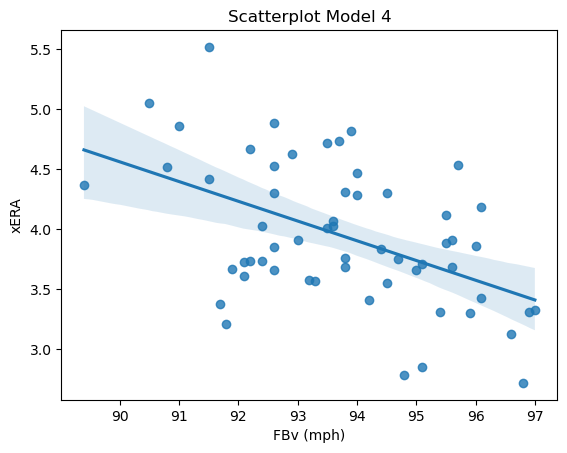

In [24]:
# Displaying a scatterplot of Model 4 
fb_v = fb_v.copy()
fb_v['y'] = pitchers_data[['xERA']]
scat4 = sns.regplot(data=fb_v, x='FBv', y='y')
plt.title('Scatterplot Model 4')
plt.xlabel('FBv (mph)')
plt.ylabel('xERA')
plt.show()

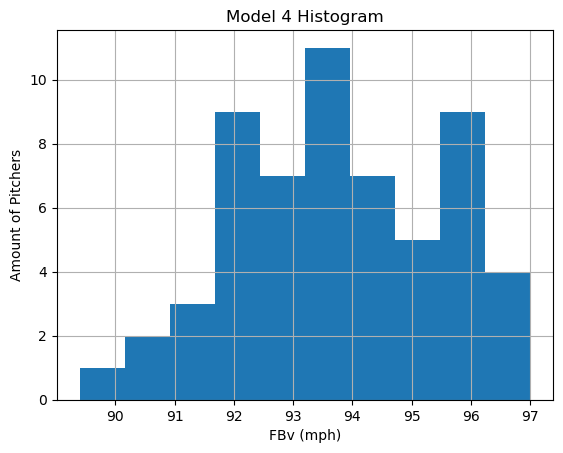

In [25]:
# Dispalying the histogram of model 4
hist4 = fb_v['FBv'].hist()
plt.title('Model 4 Histogram')
plt.xlabel('FBv (mph)')
plt.ylabel('Amount of Pitchers')
plt.show()

In [26]:
# Finding outliers in the dataset
z_scores4 = np.abs(stats.zscore(fb_v_df))
z_score_df4 = pd.DataFrame(z_scores4, columns=fb_v_df.columns)
outliers4 = np.where((z_scores4 > 3).any(axis=1))[0]
print('Outliers:', outliers4)
print('Number of outliers:', len(outliers4))

Outliers: []
Number of outliers: 0


In [27]:
# Finding high influience values
influence4 = results4.get_influence()
(c4, p4) = influence4.cooks_distance
high_influence4_df = pd.DataFrame()
high_influence4_df['cooks_d'] = c1
high_influence4_df['leverage'] = influence4.hat_matrix_diag
n4 = len(high_influence4_df)
threshold4 = 1 / n4
high_influence4_df['high_influence'] = high_influence4_df['cooks_d'] > threshold4
high_influence_indices4 = np.where(high_influence4_df['high_influence'])[0]
print(fb_v_df.loc[high_influence_indices4])
print()
print(high_influence4_df.head())

     FBv  xERA
0   94.8  2.79
1   96.8  2.72
2   95.1  2.85
4   92.2  3.74
5   96.9  3.31
14  94.2  3.41
24  91.7  3.38
29  91.8  3.21
39  92.6  4.53
43  95.7  4.54
47  91.5  5.52
51  90.5  5.05
53  93.7  4.74
57  93.5  4.72

    cooks_d  leverage  high_influence
0  0.020376  0.023551            True
1  0.038992  0.070029            True
2  0.023539  0.027642            True
3  0.003836  0.032750           False
4  0.025951  0.030693            True


In [28]:
# Removing high influence values from model
fb_v_df44 = fb_v_df
fb_v_df44 = fb_v_df44.drop(high_influence_indices4)
print(fb_v_df44.shape)
fb_v_df44.head()

(44, 2)


,FBv,xERA
3,95.4,3.31
6,94.5,3.55
7,92.6,4.30
8,96.1,3.43
9,96.6,3.13


In [29]:
# Model 4 without high influence values
fb_v44 = fb_v_df44[['FBv']]
x44 = MS(fb_v44).fit_transform(fb_v_df44)
y44 = fb_v_df44[['xERA']]
model44 = sm.OLS(y44, x44)
results44 = model44.fit()
results44.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xERA   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     14.98
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           0.000373
Time:                        11:07:46   Log-Likelihood:                -19.298
No. Observations:                  44   AIC:                             42.60
Df Residuals:                      42   BIC:                             46.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.5079      3.242      5.092      0.000       9.965      23.050
FBv           -0.1338      0.035     -3.870      0.000      -0.204      -0.064
==============================================================================
Omnibus:                        3.010   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.222   Jarque-Bera (JB):                2.305
Skew:                           0.411   Prob(JB):                        0.316
Kurtosis:                       2.237   Cond. No.                     5.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Model 5: Inverse Fastball
* Performing an inverse transaformation to see how the model reacts to the transformation.

In [70]:
inv_fb_v_df = pitchers_data[['FBv', 'xERA']]
inv_fb_v_df['inv_fb_v'] = 1 / inv_fb_v_df['FBv']
inv_fb_v_df = inv_fb_v_df.copy()
inv_fb = inv_fb_v_df[['inv_fb_v']]
x5 = MS(inv_fb).fit_transform(inv_fb_v_df)
y5 = inv_fb_v_df[['xERA']]
model5 = sm.OLS(y5, x5)
results5 = model5.fit()
results5.summary()

/var/folders/y2/ffmphcn51c18jj38jsf88tyc0000gn/T/ipykernel_78986/1033041533.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inv_fb_v_df['inv_fb_v'] = 1 / inv_fb_v_df['FBv']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xERA   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     17.90
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           8.71e-05
Time:                        11:26:32   Log-Likelihood:                -42.900
No. Observations:                  58   AIC:                             89.80
Df Residuals:                      56   BIC:                             93.92
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -11.3986      3.628     -3.142      0.003     -18.666      -4.131
inv_fb_v    1438.0623    339.903      4.231      0.000     757.154    2118.970
==============================================================================
Omnibus:                        0.642   Durbin-Watson:                   1.351
Prob(Omnibus):                  0.725   Jarque-Bera (JB):                0.732
Skew:                           0.098   Prob(JB):                        0.693
Kurtosis:                       2.486   Cond. No.                     5.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

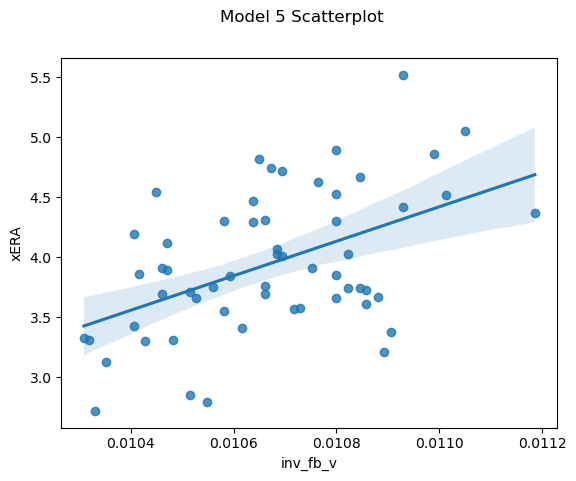

In [71]:
# Displaying a scatterplot of Model 5 
inv_fb_v_df = inv_fb_v_df.drop('FBv', axis= 1)
scat5 = sns.regplot(data=inv_fb_v_df, x='inv_fb_v', y='xERA')
fig5 = scat5.figure
fig5.suptitle('Model 5 Scatterplot')
plt.show()

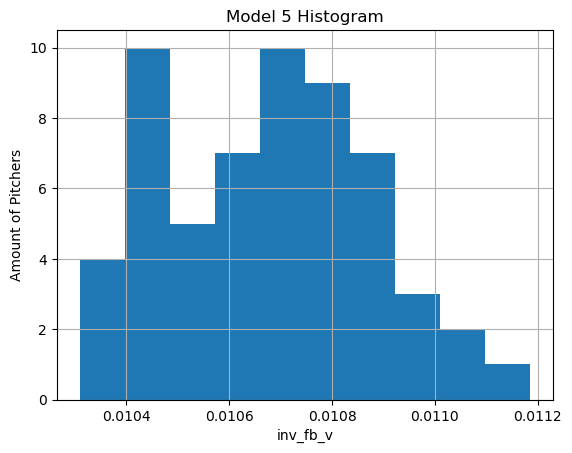

In [68]:
# Dispalying the histogram of model 5
hist5 = inv_fb_v_df['inv_fb_v'].hist()
plt.title('Model 5 Histogram')
plt.xlabel('inv_fb_v')
plt.ylabel('Amount of Pitchers')
plt.show()

In [33]:
# Finding outliers in the dataset
z_scores5 = np.abs(stats.zscore(inv_fb_v_df))
z_score_df5 = pd.DataFrame(z_scores5, columns=inv_fb_v_df.columns)
outliers5 = np.where((z_scores5 > 3).any(axis=1))[0]
print('Outliers:', outliers5)
print('Number of outliers:', len(outliers5))

Outliers: []
Number of outliers: 0


In [34]:
# Finding high influence values
influence5 = results5.get_influence()
(c5, p5) = influence5.cooks_distance
high_influence5_df = pd.DataFrame()
high_influence5_df['cooks_d'] = c5
high_influence5_df['leverage'] = influence5.hat_matrix_diag
n5 = len(high_influence5_df)
threshold5 = 1 / n5
high_influence5_df['high_influence'] = high_influence5_df['cooks_d'] > threshold5
high_influence_indices5 = np.where(high_influence5_df['high_influence'])[0]
print(inv_fb_v_df.loc[high_influence_indices5])
print()
print(high_influence5_df.head())

    xERA  inv_fb_v
0   2.79  0.010549
1   2.72  0.010331
2   2.85  0.010515
23  4.19  0.010406
24  3.38  0.010905
27  3.61  0.010858
28  4.82  0.010650
29  3.21  0.010893
31  3.67  0.010881
43  4.54  0.010449
47  5.52  0.010929
49  4.37  0.011186
50  4.86  0.010989
51  5.05  0.011050
53  4.74  0.010672
56  4.89  0.010799
57  4.72  0.010695

    cooks_d  leverage  high_influence
0  0.045069  0.023769            True
1  0.079404  0.067584            True
2  0.042091  0.027792            True
3  0.008779  0.032742           False
4  0.012823  0.030505           False


In [35]:
# Removing high influence values
inv_fb_v_df55 = inv_fb_v_df
inv_fb_v_df55 = inv_fb_v_df55.drop(high_influence_indices5)
inv_fb_v_df55.head()

,xERA,inv_fb_v
3,3.31,0.010482
4,3.74,0.010846
5,3.31,0.010320
6,3.55,0.010582
7,4.30,0.010799


In [36]:
# Model 5 without high influence values
inv_fb55 = inv_fb_v_df55[['inv_fb_v']]
x55 = MS(inv_fb55).fit_transform(inv_fb_v_df55)
y55 = inv_fb_v_df55[['xERA']]
model55 = sm.OLS(y55, x55)
results55 = model55.fit()
results55.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   xERA   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     21.30
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           4.18e-05
Time:                        11:07:46   Log-Likelihood:                -11.119
No. Observations:                  41   AIC:                             26.24
Df Residuals:                      39   BIC:                             29.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -10.6531      3.149     -3.383      0.002     -17.022      -4.284
inv_fb_v    1365.9458    295.938      4.616      0.000     767.354    1964.538
==============================================================================
Omnibus:                        5.852   Durbin-Watson:                   1.096
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                2.423
Skew:                           0.260   Prob(JB):                        0.298
Kurtosis:                       1.929   Cond. No.                     5.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Model 6: Inverse xERA
* Performing an inverse transaformation to see how the model reacts to the transformation.

In [37]:
inv_xera_df = pitchers_data[['FBv', 'xERA']]
inv_xera_df['inv_xera'] = 1 / inv_xera_df['xERA']
x6 = MS(inv_xera_df[['FBv']]).fit_transform(inv_xera_df)
y6 = inv_xera_df[['inv_xera']]
model6 = sm.OLS(y6, x6)
results6 = model6.fit()
results6.summary()

/var/folders/y2/ffmphcn51c18jj38jsf88tyc0000gn/T/ipykernel_78986/19345264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inv_xera_df['inv_xera'] = 1 / inv_xera_df['xERA']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               inv_xera   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     17.68
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           9.52e-05
Time:                        11:07:46   Log-Likelihood:                 113.64
No. Observations:                  58   AIC:                            -223.3
Df Residuals:                      56   BIC:                            -219.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.7693      0.245     -3.145      0.003      -1.259      -0.279
FBv            0.0110      0.003      4.205      0.000       0.006       0.016
==============================================================================
Omnibus:                        3.123   Durbin-Watson:                   1.171
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.714
Skew:                           0.530   Prob(JB):                        0.257
Kurtosis:                       2.965   Cond. No.                     5.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

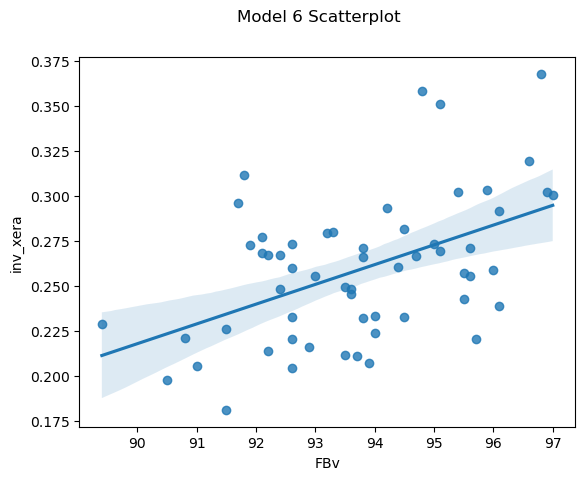

In [67]:
# Displaying a scatterplot of Model 6
scat6 = sns.regplot(data=inv_xera_df, x='FBv', y='inv_xera')
fig6 = scat6.figure
fig6.suptitle('Model 6 Scatterplot')
plt.show()

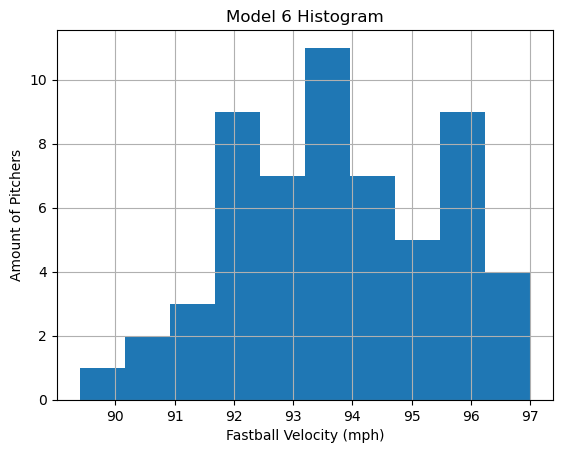

In [73]:
# Dispalying the histogram of model 6
hist6 = inv_xera_df['FBv'].hist()
plt.title('Model 6 Histogram')
plt.xlabel('Fastball Velocity (mph)')
plt.ylabel('Amount of Pitchers')
plt.show()

In [40]:
# Finding outliers in the dataset
z_scores6 = np.abs(stats.zscore(inv_xera_df))
z_score_df6 = pd.DataFrame(z_scores6, columns=inv_xera_df.columns)
outliers6 = np.where((z_scores6 > 3).any(axis=1))[0]
print('Outliers:', outliers6)
print('Number of outliers:', len(outliers6))

Outliers: []
Number of outliers: 0


In [41]:
# Finding high influence values
influence6 = results6.get_influence()
(c6, p6) = influence6.cooks_distance
high_influence6_df = pd.DataFrame()
high_influence6_df['cooks_d'] = c6
high_influence6_df['leverage'] = influence6.hat_matrix_diag
n6 = len(high_influence6_df)
threshold6 = 1 / n6
high_influence6_df['high_influence'] = high_influence6_df['cooks_d'] > threshold6
high_influence_indices6 = np.where(high_influence6_df['high_influence'])[0]
print(inv_xera_df.loc[high_influence_indices6])
print()
print(high_influence6_df.head())

     FBv  xERA  inv_xera
0   94.8  2.79  0.358423
1   96.8  2.72  0.367647
2   95.1  2.85  0.350877
9   96.6  3.13  0.319489
23  96.1  4.19  0.238663
24  91.7  3.38  0.295858
27  92.1  3.61  0.277008
28  93.9  4.82  0.207469
29  91.8  3.21  0.311526
31  91.9  3.67  0.272480
43  95.7  4.54  0.220264
47  91.5  5.52  0.181159
48  95.5  4.12  0.242718
49  89.4  4.37  0.228833
51  90.5  5.05  0.198020
56  92.6  4.89  0.204499

    cooks_d  leverage  high_influence
0  0.079076  0.023551            True
1  0.189602  0.070029            True
2  0.071923  0.027642            True
3  0.009036  0.032750           False
4  0.008682  0.030693           False


In [42]:
# Removing high influence values
inv_xera_df66 = inv_xera_df
inv_xera_df66 = inv_xera_df.drop(high_influence_indices6)
print(inv_xera_df66.shape)
inv_xera_df66.head()

(42, 3)


,FBv,xERA,inv_xera
3,95.4,3.31,0.302115
4,92.2,3.74,0.267380
5,96.9,3.31,0.302115
6,94.5,3.55,0.281690
7,92.6,4.30,0.232558


In [43]:
# Model 6 without outliers
x66 = MS(inv_xera_df66[['FBv']]).fit_transform(inv_xera_df66)
y66 = inv_xera_df66[['inv_xera']]
model66 = sm.OLS(y66, x66)
results66 = model66.fit()
results66.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               inv_xera   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     23.50
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           1.92e-05
Time:                        11:07:46   Log-Likelihood:                 101.24
No. Observations:                  42   AIC:                            -198.5
Df Residuals:                      40   BIC:                            -195.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.7888      0.216     -3.660      0.001      -1.224      -0.353
FBv            0.0111      0.002      4.848      0.000       0.006       0.016
==============================================================================
Omnibus:                        4.681   Durbin-Watson:                   1.100
Prob(Omnibus):                  0.096   Jarque-Bera (JB):                1.970
Skew:                          -0.141   Prob(JB):                        0.373
Kurtosis:                       1.977   Cond. No.                     5.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Conclusion
* It is quite evident that mutlicollinearity is prevelant in most of the models because velocity is going to correlate highly between the different pitch types. For example, someone who throws their fastball 100 mph would be exoected to throw their cutter faster than someone who throws their fastball 95 mph. Also, there are many factors that play a part in a pitchers xERA, so a coefficent of determination score of roughly .250 is expected. Lastly, it is not necessary to use the models without the high influence values because the data was correctly collected, and the high influence values actaully provide important information to the different models. However, removing the high influence values did improve the models with only fastball velocity as a predictor variable.